In [173]:
suppressWarnings({
    library(lmerTest)
    library(lme4)
    library(ggplot2)
    library(dplyr)
    library(tidyr)
    library(sjPlot)
    library(IRdisplay)
    library(car)
    library(ggeffects)
    library(gridExtra)
})



Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



# Investigating MHWs + Phytoplankton Performance Response via LMMs

Tony Cannistra, May 2020

**Purpose**: To experiment with linear mixed effects models to examine whether a significant relationship exists between latitude, sea surface temperature, and performance ratio during marine heatwave events. 

**Method**: Build a linear mixed model of performance ratio with the following effects: 

*Fixed*: 
* latitude + Latitude ^2
* mean_sst_event_year_local

*Random*:
* phytoplankton isolate
* season?

Perhaps season should be a fixed effect, especially since it likely does have control over the direction + shape of the curve. 

## Data

We compute individual isolate performance for all local heatwaves in [this notebook](../Individual_Isolate_performance.ipynb), and use these data below. 

In [26]:
mhwPerformance <- read.csv("../isolate_performance.csv")
mhwPerformance = mhwPerformance %>% mutate(isolate = factor(isolate))
head(mhwPerformance)

X,lat,lon,isolate,mhw,detriment_sum,relative_detriment_mean,detriment_mean,performance_diff_sum,performance_ratio_mean,...,intensity_mean,duration,start_doy,peak_doy,current_year_sst_mean,start_date,peak_date,perf_det_ratio,latbin,doy_bins
0,-74.875,164.625,1,4,2.632757,1,0.3290947,0,NA,...,1.2978105,9,1,1,-1.202301,1986-12-31,1987-01-01,1,"(-75.026, -59.75]","(0.639, 91.25]"
1,-74.875,164.625,1,5,4.936420,1,0.3290947,0,NA,...,1.5283193,16,21,32,-1.103370,1987-01-21,1987-02-01,1,"(-75.026, -59.75]","(0.639, 91.25]"
2,-74.875,164.625,1,11,5.594609,1,0.3290947,0,NA,...,0.1877301,18,232,244,-1.168743,1988-08-19,1988-08-31,1,"(-75.026, -59.75]","(181.5, 271.75]"
3,-74.875,164.625,1,14,5.923704,1,0.3290947,0,NA,...,0.1741022,19,196,201,-1.181397,1989-07-15,1989-07-20,1,"(-75.026, -59.75]","(181.5, 271.75]"
4,-74.875,164.625,1,37,3.620041,1,0.3290947,0,NA,...,0.1560303,12,215,220,-1.219370,1995-08-03,1995-08-08,1,"(-75.026, -59.75]","(181.5, 271.75]"
5,-74.875,164.625,1,69,3.290947,1,0.3290947,0,NA,...,0.1353238,11,133,138,-1.088333,2004-05-12,2004-05-17,1,"(-75.026, -59.75]","(91.25, 181.5]"


We need to adjust for the effect of hemisphere to "align" seasons and convert to "season" factor variables from "peak_doy" column:

In [27]:
mhwPerformance[between(mhwPerformance$lat, -90, 0), 'peak_doy'] = (mhwPerformance[between(mhwPerformance$lat, -90, 0), 'peak_doy'] - 180) %% 365

In [28]:
mhwPerformance = mhwPerformance %>%  
                    mutate(season = 
                           case_when(
                                (between(peak_doy, 0, 77) | between(peak_doy, 355, 366)) ~ "winter", # January 1 - March XX or December XX - December 31
                                between(peak_doy, 78, 170) ~ "spring", # March XX - June XX
                                between(peak_doy, 171, 295) ~ "summer", # June XX - September XX
                                between(peak_doy, 296, 354) ~ "fall" # September XX - December XX
                        )
                    )

In [29]:
head(mhwPerformance %>% select(peak_doy, season))

peak_doy,season
186,summer
217,summer
64,winter
21,winter
40,winter
323,fall


We'll clean up by dropping NAs and `Inf`s 

In [30]:
mhwPerformance = mhwPerformance %>% filter(!is.na(performance_ratio_mean)) %>% filter(is.finite(performance_ratio_mean))

We'll also **scale the input variables** for later, but the initial models will use the raw values: 

In [31]:
mhwPerformance = mhwPerformance %>%
    mutate(
        lat_scaled = scale(lat),
        sst_scaled = scale(current_year_sst_mean), 
        abslat_scaled = scale(abs(lat))
    )

## Is `season` a random or fixed effect?

Warning message:
“Removed 95 rows containing non-finite values (stat_boxplot).”

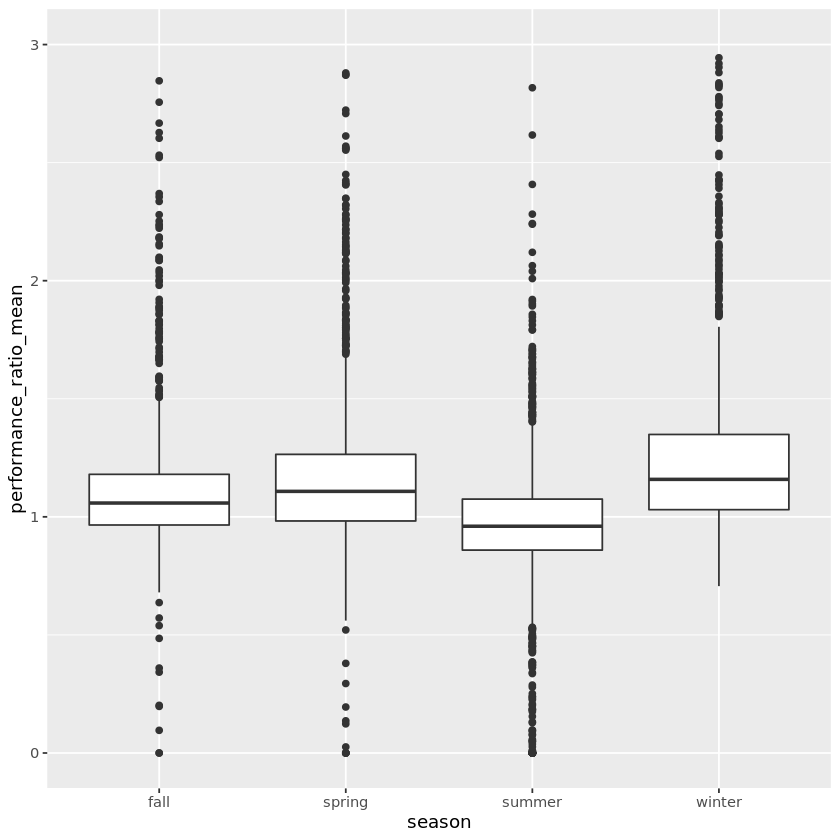

In [32]:
ggplot(mhwPerformance, aes(x = season, y = performance_ratio_mean)) + geom_boxplot() + ylim(0, 3)

## Models

We'll start with a simple linear model with all terms, **excluding** interaction terms:

In [48]:
simple_lm = lm(performance_ratio_mean ~ (poly(lat_scaled, 2) + sst_scaled + season)  , data=mhwPerformance)
summary(simple_lm)


Call:
lm(formula = performance_ratio_mean ~ (poly(lat_scaled, 2) + 
    sst_scaled + season), data = mhwPerformance)

Residuals:
    Min      1Q  Median      3Q     Max 
 -1.788  -0.388  -0.122   0.058 219.367 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)           1.15671    0.13195   8.766   <2e-16 ***
poly(lat_scaled, 2)1  4.37562    3.57955   1.222   0.2216    
poly(lat_scaled, 2)2  0.16701    8.94564   0.019   0.9851    
sst_scaled           -0.09255    0.12758  -0.725   0.4682    
seasonspring          0.39971    0.16563   2.413   0.0158 *  
seasonsummer         -0.19750    0.15533  -1.271   0.2036    
seasonwinter          0.34825    0.17394   2.002   0.0453 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.575 on 4912 degrees of freedom
Multiple R-squared:  0.006504,	Adjusted R-squared:  0.00529 
F-statistic: 5.359 on 6 and 4912 DF,  p-value: 1.586e-05


In [49]:
baseline_hline = geom_hline(yintercept=1, linetype='dashed', color='blue', size=0.6, alpha=0.6)

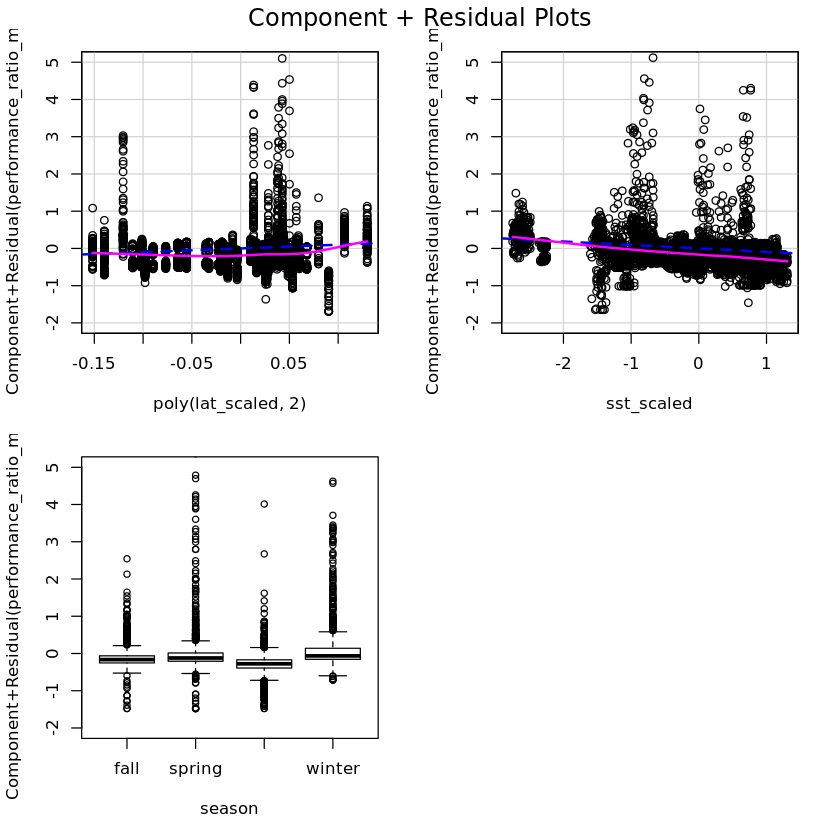

In [54]:
crPlots(simple_lm, ylim=c(-2, 5))


## Simple Model with Random Effects

Only `isolate` as random effect for now: 

In [243]:
simple_re = lmer(performance_ratio_mean ~ (poly(lat_scaled, 2) + sst_scaled + season)^2 + (1|isolate), data=mhwPerformance)
summary(simple_re)


Correlation matrix not shown by default, as p = 18 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: performance_ratio_mean ~ (poly(lat_scaled, 2) + sst_scaled +  
    season)^2 + (1 | isolate)
   Data: mhwPerformance

REML criterion at convergence: 26327

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-1.763 -0.090 -0.017  0.052 60.933 

Random effects:
 Groups   Name        Variance Std.Dev.
 isolate  (Intercept)  1.238   1.113   
 Residual             12.161   3.487   
Number of obs: 4919, groups:  isolate, 73

Fixed effects:
                                    Estimate Std. Error         df t value
(Intercept)                        1.162e+00  2.223e-01  1.037e+02   5.227
poly(lat_scaled, 2)1               1.258e+01  1.636e+01  9.178e+01   0.769
poly(lat_scaled, 2)2               7.838e+00  3.737e+01  1.547e+02   0.210
sst_scaled                         1.227e-01  4.724e-01  2.623e+02   0.260
seasonspring                       4.723e-01  1.630e-01  4.837e+03   2.898
seasonsummer 

Model contains splines or polynomial terms. Consider using `terms="lat_scaled [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.


Error: Confidence intervals could not be computed.
* Reason: "`season` does not have enough factor levels. Try to remove `[]`."
* Source: .safe_se_from_vcov(model, prediction_data, value_adjustment, terms, model_class, type, vcov.fun, vcov.type, vcov.args, condition, interval)


Model contains splines or polynomial terms. Consider using `terms="sst_scaled [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.


Error: Confidence intervals could not be computed.
* Reason: "`season` does not have enough factor levels. Try to remove `[]`."
* Source: .safe_se_from_vcov(model, prediction_data, value_adjustment, terms, model_class, type, vcov.fun, vcov.type, vcov.args, condition, interval)


Model contains splines or polynomial terms. Consider using `terms="season [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.


NULL

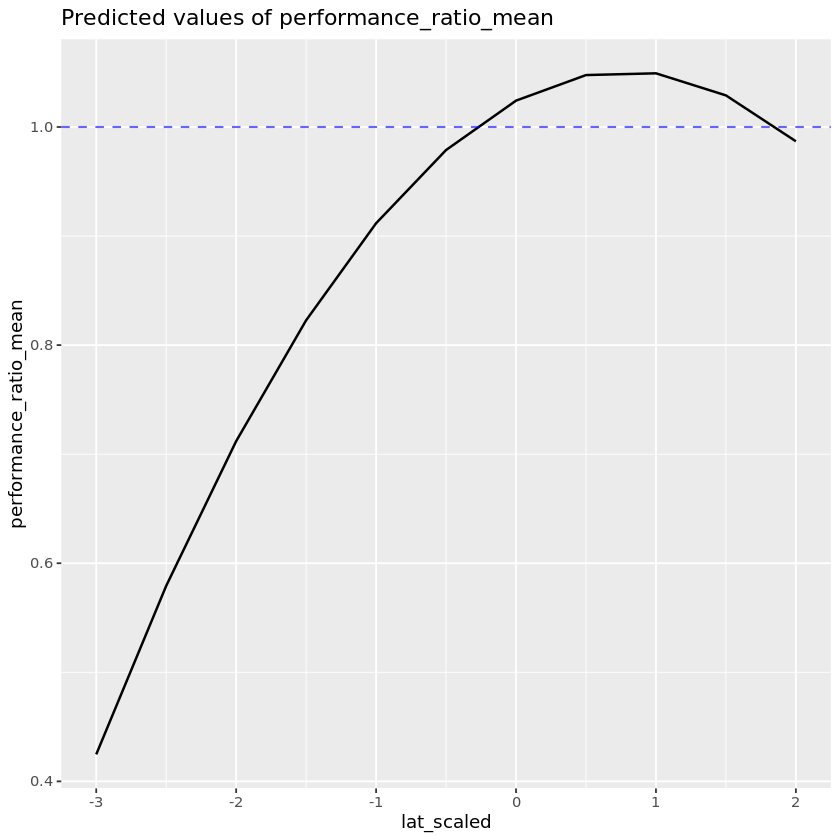

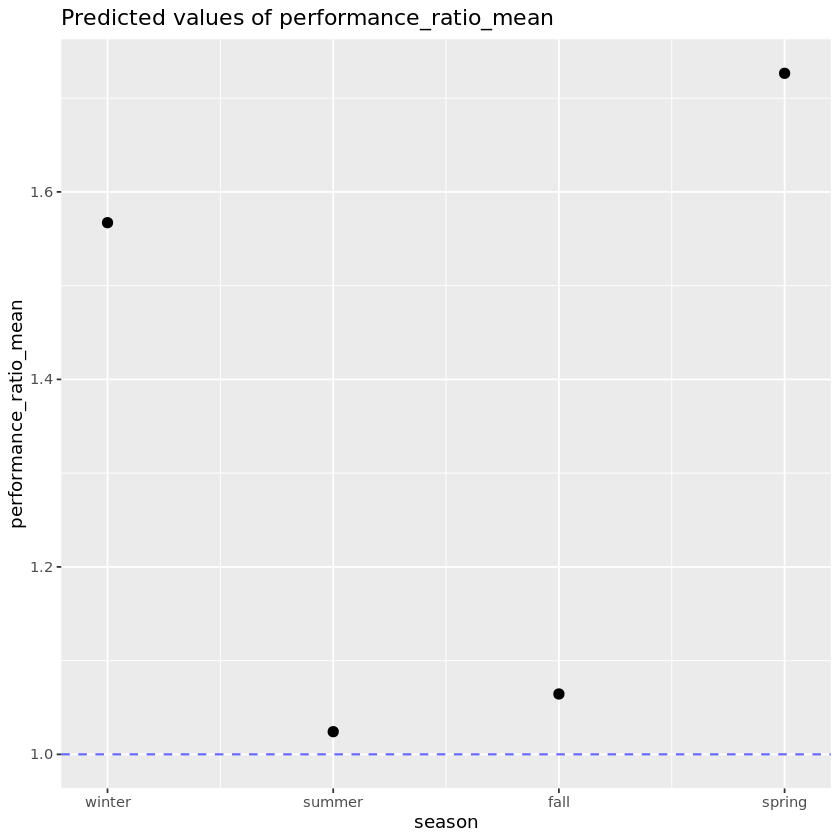

In [244]:
simple_re_plots = plot_model(simple_re, type='pred')
simple_re_plots$lat + baseline_hline
simple_re_plots$current_year_sst_mean + baseline_hline
simple_re_plots$season + baseline_hline

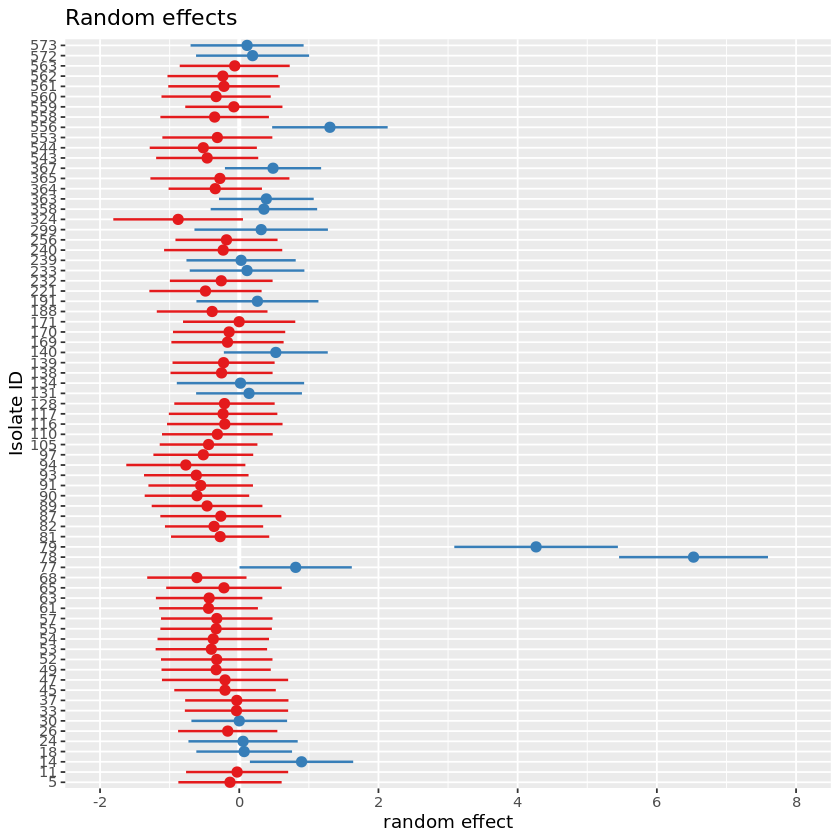

In [33]:
plot_model(simple_re, type='re') + xlab("Isolate ID") + ylab('random effect')

**Random Effects model with Season**

In [68]:
season_re = lmer(performance_ratio_mean ~ poly(lat,2) + current_year_sst_mean + poly(lat,2)*current_year_sst_mean + season-1  +  (1 | isolate), data=mhwPerformance)
summary(season_re)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: performance_ratio_mean ~ poly(lat, 2) + current_year_sst_mean +  
    poly(lat, 2) * current_year_sst_mean + season - 1 + (1 |      isolate)
   Data: mhwPerformance

REML criterion at convergence: 26380.3

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-1.768 -0.088 -0.015  0.054 60.987 

Random effects:
 Groups   Name        Variance Std.Dev.
 isolate  (Intercept)  1.228   1.108   
 Residual             12.152   3.486   
Number of obs: 4919, groups:  isolate, 73

Fixed effects:
                                    Estimate Std. Error       df t value
poly(lat, 2)1                       -5.98875   17.49426 51.17217  -0.342
poly(lat, 2)2                        6.19252   23.78501 63.67286   0.260
current_year_sst_mean                0.00793    0.04610 78.83987   0.172
seasonfall                           1.00384    0.89473 81.38607   1.122
seasonspring                         1.47188    

Model contains splines or polynomial terms. Consider using `terms="lat [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.


Error: Confidence intervals could not be computed.
* Reason: "`season` does not have enough factor levels. Try to remove `[]`."
* Source: .safe_se_from_vcov(model, prediction_data, value_adjustment, terms, model_class, type, vcov.fun, vcov.type, vcov.args, condition, interval)


Model contains splines or polynomial terms. Consider using `terms="current_year_sst_mean [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.


Error: Confidence intervals could not be computed.
* Reason: "`season` does not have enough factor levels. Try to remove `[]`."
* Source: .safe_se_from_vcov(model, prediction_data, value_adjustment, terms, model_class, type, vcov.fun, vcov.type, vcov.args, condition, interval)


Model contains splines or polynomial terms. Consider using `terms="season [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.


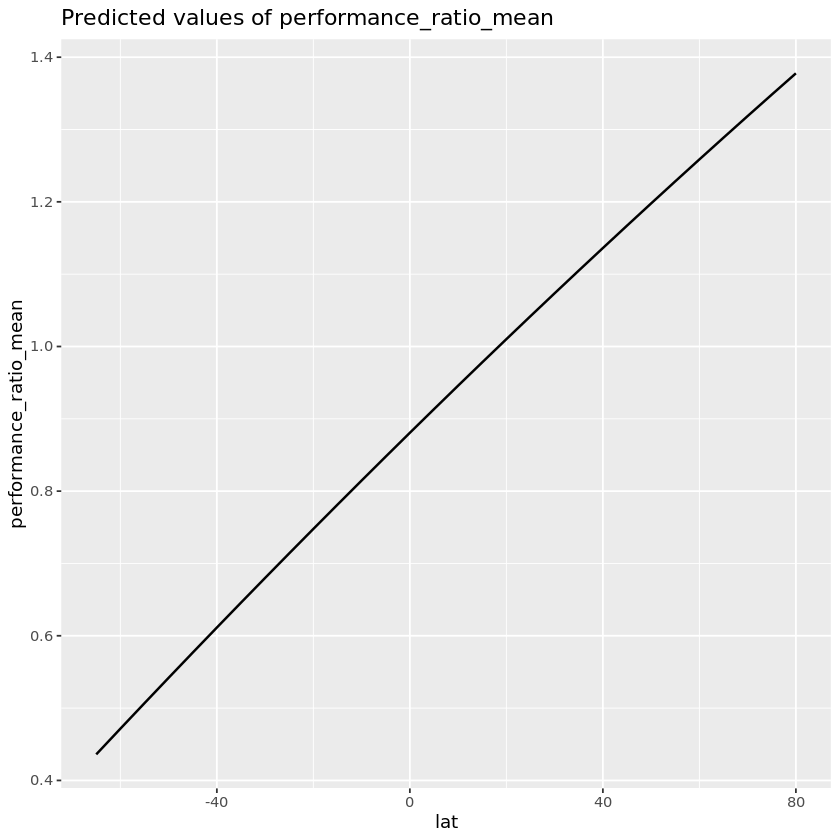

$lat

$current_year_sst_mean

$season


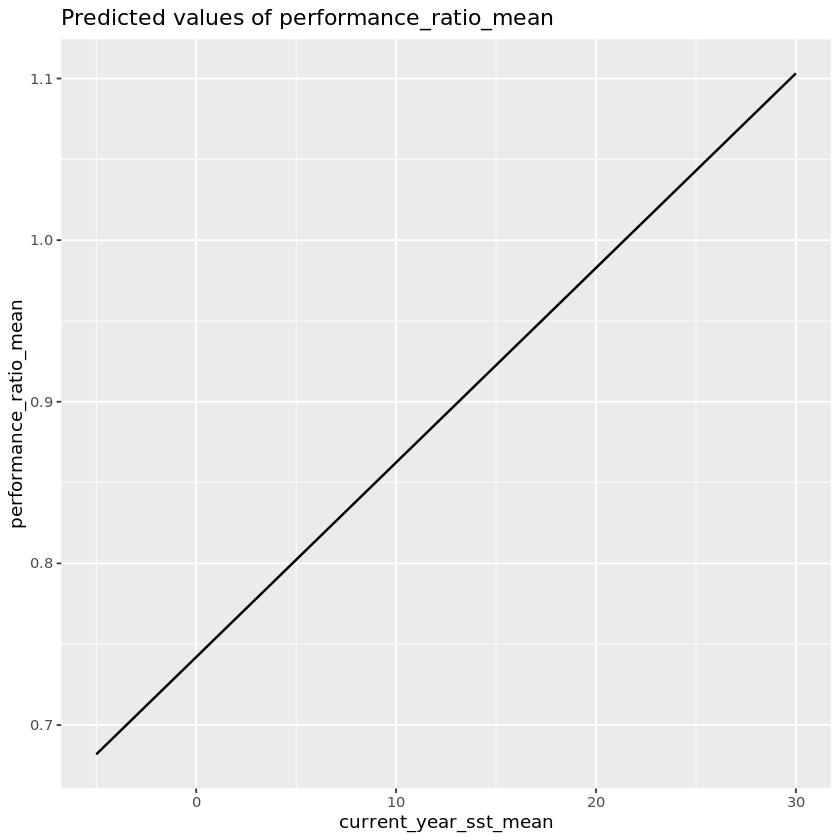

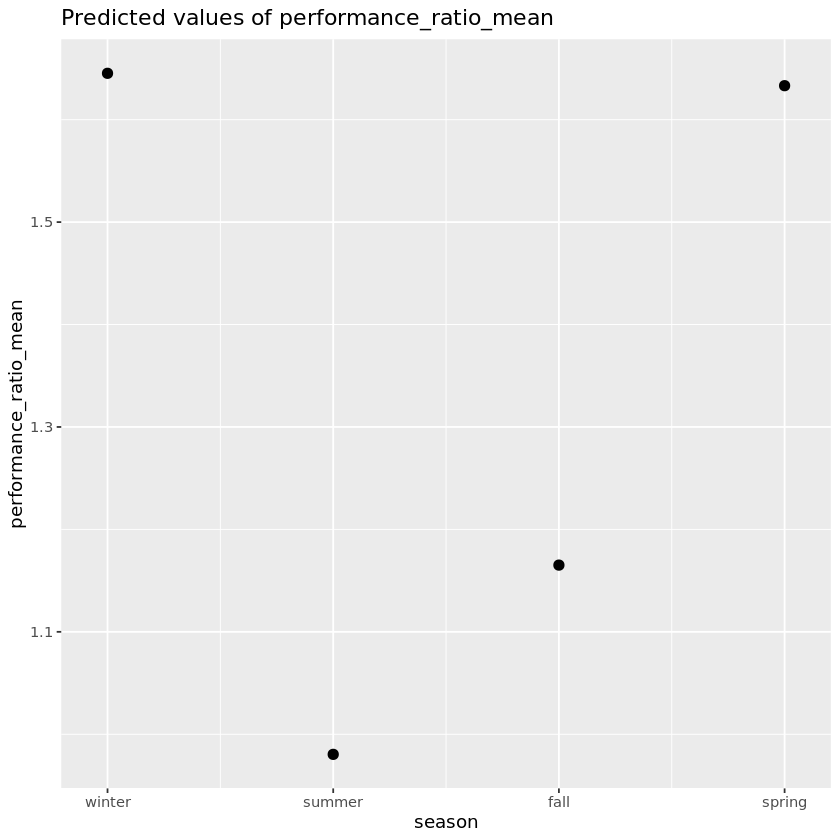

In [69]:
plot_model(season_re, type='pred')

## More Intense Heatwaves =? Stronger Signal?

There's probably a lot of noise from shorter events here. 

Lets take a look at the distribution of heatwaves by intensity: 

In [61]:
median(mhwPerformance$intensity_mean)

[1] 1.541905

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


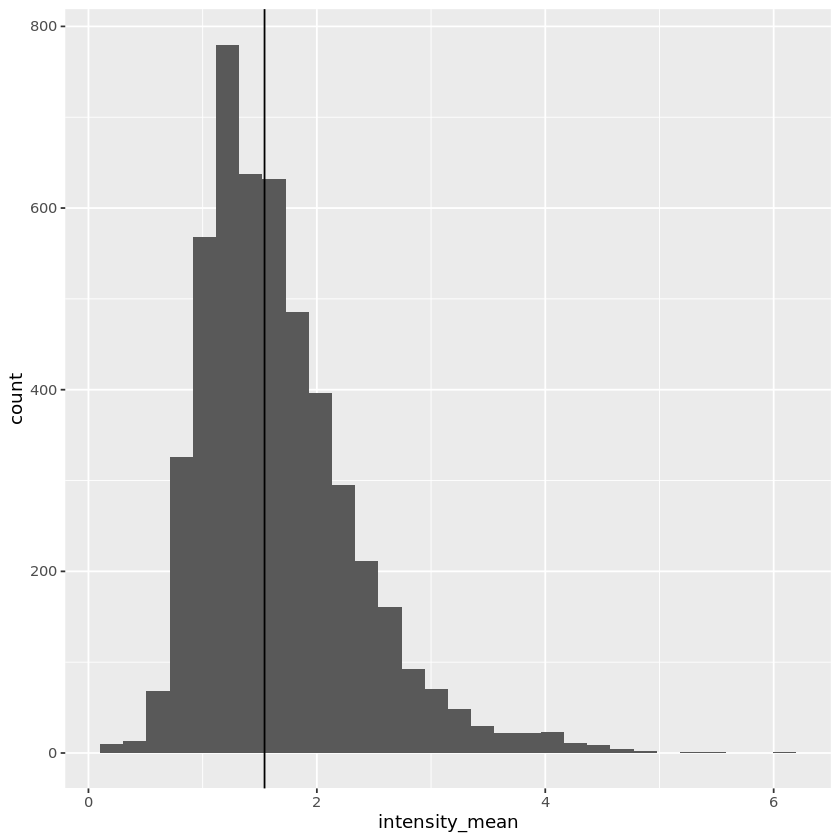

In [62]:
ggplot(mhwPerformance, aes(x=intensity_mean) ) + geom_histogram() + geom_vline(xintercept=median(mhwPerformance$intensity_mean)) 

We can use ~1.5 C as our threshold (median?)

In [63]:
intensity_threshold = 1.5

In [64]:
intenseMhwPerformance = mhwPerformance %>% filter(intensity_mean > intensity_threshold)

In [65]:
head(intenseMhwPerformance)

X,lat,lon,isolate,mhw,detriment_sum,relative_detriment_mean,detriment_mean,performance_diff_sum,performance_ratio_mean,...,current_year_sst_mean,start_date,peak_date,perf_det_ratio,latbin,doy_bins,season,lat_scaled,sst_scaled,abslat_scaled
19,-57.875,139.875,558,6,0.8048469,0.14412670,0.04734394,-0.7973536,0.8569843,...,2.37748,1985-01-03,1985-01-05,3.234330e+04,"(-59.75, -44.625]","(0.639, 91.25]",summer,-2.322601,-2.3233394,1.6488743
27,-41.375,174.875,18,30,1.2221654,0.09605062,0.02909918,0.9946192,1.0947682,...,14.94652,1999-02-08,1999-03-18,5.517525e-01,"(-44.625, -29.5]","(0.639, 91.25]",summer,-1.799260,-0.6469757,0.6339405
34,-36.125,174.875,573,53,1.7526555,0.07958929,0.04736907,3.0075834,1.1757085,...,17.80997,2017-11-28,2017-12-11,3.521463e-01,"(-44.625, -29.5]","(0.639, 91.25]",spring,-1.632742,-0.2650704,0.3110070
37,-34.375,17.125,26,42,0.2014159,0.08242058,0.03356932,-0.1750949,0.9275738,...,18.40364,2005-07-15,2005-07-17,7.700049e+00,"(-44.625, -29.5]","(181.5, 271.75]",winter,-1.577236,-0.1858907,0.2033625
38,-34.375,17.125,26,45,4.8919199,0.48043255,0.19567680,-2.2139308,0.7046092,...,19.01186,2007-03-01,2007-03-19,1.827904e+00,"(-44.625, -29.5]","(0.639, 91.25]",summer,-1.577236,-0.1047713,0.2033625
39,-34.375,17.125,26,52,0.9720365,0.10376427,0.04226246,-0.8349681,0.9094785,...,18.62331,2009-06-28,2009-07-04,7.073921e+00,"(-44.625, -29.5]","(91.25, 181.5]",winter,-1.577236,-0.1565929,0.2033625


In [66]:
nrow(intenseMhwPerformance)

[1] 2597

**Simple Model**

In [90]:
simple_intense_lm = lm(performance_ratio_mean ~ (abs(lat) +current_year_sst_mean +  season)^2, data=intenseMhwPerformance)
summary(simple_intense_lm)


Call:
lm(formula = performance_ratio_mean ~ (abs(lat) + current_year_sst_mean + 
    season)^2, data = intenseMhwPerformance)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.5905 -0.2434 -0.0629  0.0915 24.9811 

Coefficients:
                                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)                         1.7414743  0.5246788   3.319 0.000916 ***
abs(lat)                           -0.0097249  0.0080307  -1.211 0.226015    
current_year_sst_mean              -0.0291146  0.0169310  -1.720 0.085625 .  
seasonspring                        0.8290874  0.5978332   1.387 0.165616    
seasonsummer                        0.4337479  0.5675356   0.764 0.444779    
seasonwinter                       -1.0945946  0.6608623  -1.656 0.097780 .  
abs(lat):current_year_sst_mean      0.0005170  0.0001852   2.792 0.005282 ** 
abs(lat):seasonspring              -0.0029516  0.0084193  -0.351 0.725939    
abs(lat):seasonsummer              -0.0054437  0.0080472  -0.6

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


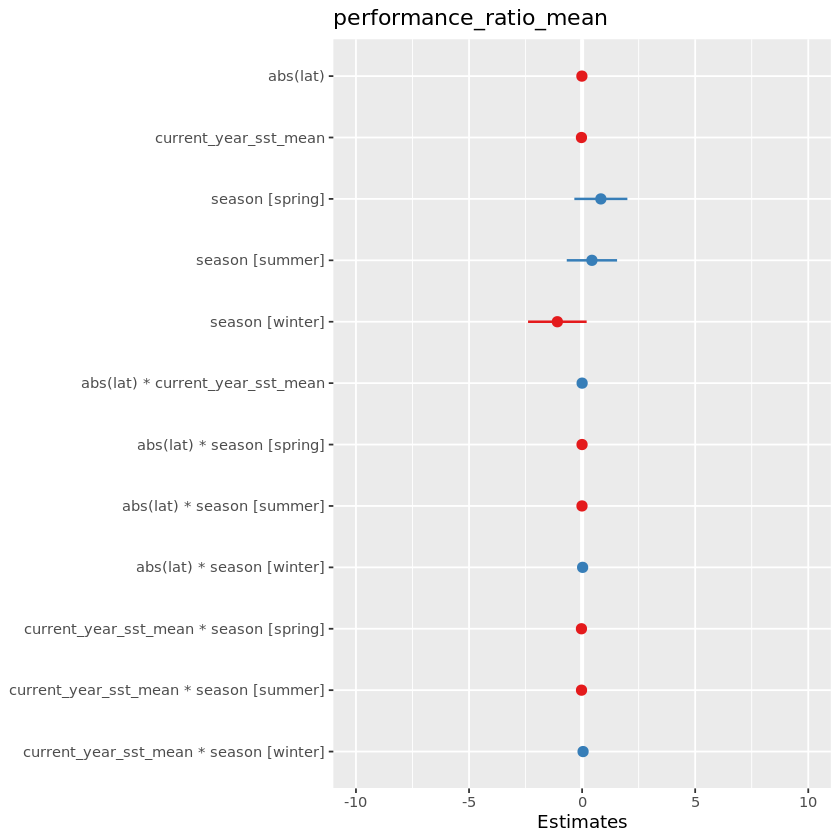

In [91]:
plot_model(simple_intense_lm)+ ylim(-10, 10)

`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 0.985”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 2.015”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  1.7639e-16”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 4.0602”

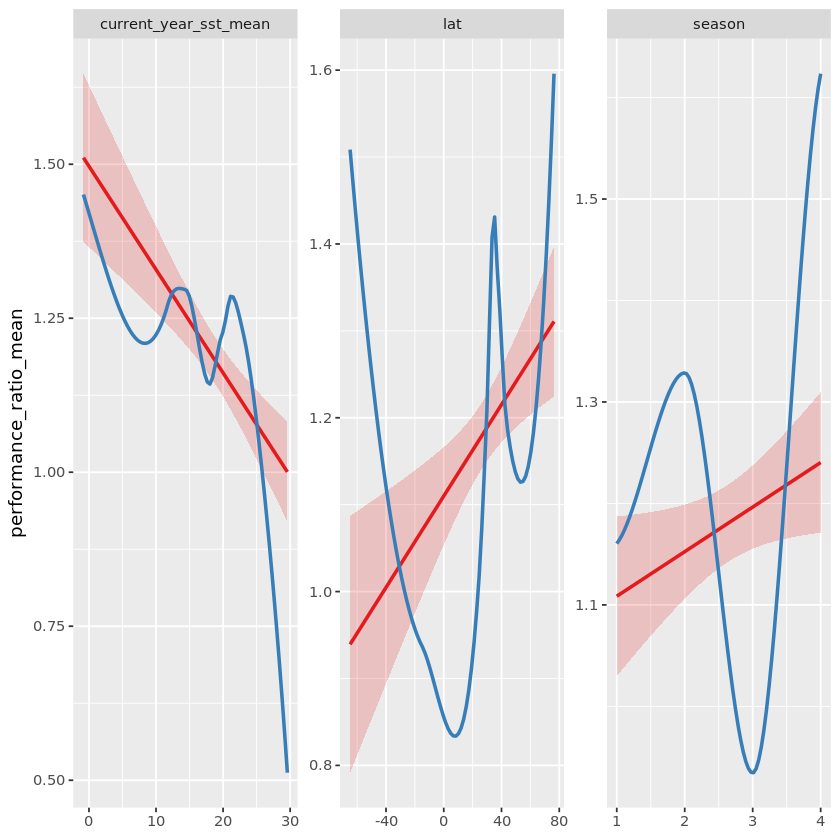

In [93]:
plot_model(simple_intense_lm, type='slope',)

**Simple Random Effects**

In [230]:
simple_intense_re = lmer(performance_ratio_mean ~ (poly(lat,2) + current_year_sst_mean  + season)^2 + (1 | isolate), data=intenseMhwPerformance, )

Warning message:
“Some predictor variables are on very different scales: consider rescaling”Warning message:
“Some predictor variables are on very different scales: consider rescaling”

In [231]:
simple_intense_scaled_re = lmer(performance_ratio_mean ~ (poly(lat_scaled,2) + sst_scaled  + season)^2 + (1 | isolate), data=intenseMhwPerformance, )

In [227]:
anova(simple_intense_re, simple_intense_scaled_re)

refitting model(s) with ML (instead of REML)


,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
simple_intense_re,20,6727.441,6844.683,-3343.721,6687.441,NA,NA,NA
simple_intense_scaled_re,20,6727.441,6844.683,-3343.721,6687.441,3.637979e-12,0,0


Model contains splines or polynomial terms. Consider using `terms="season [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.


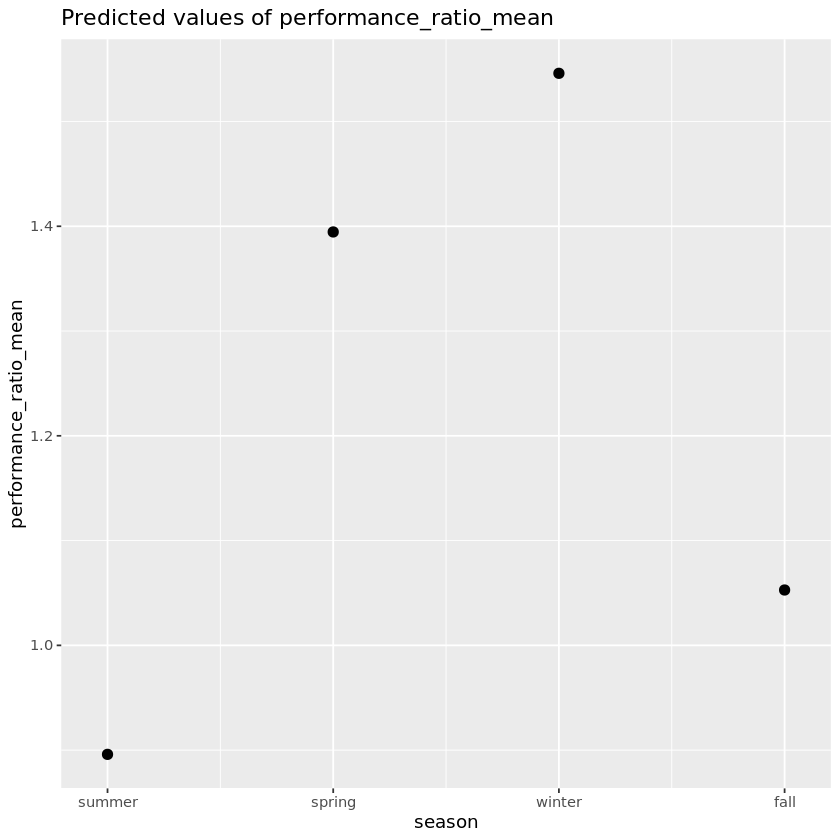

In [216]:
plot_model(simple_intense_re, type='pred', terms=c("season"))

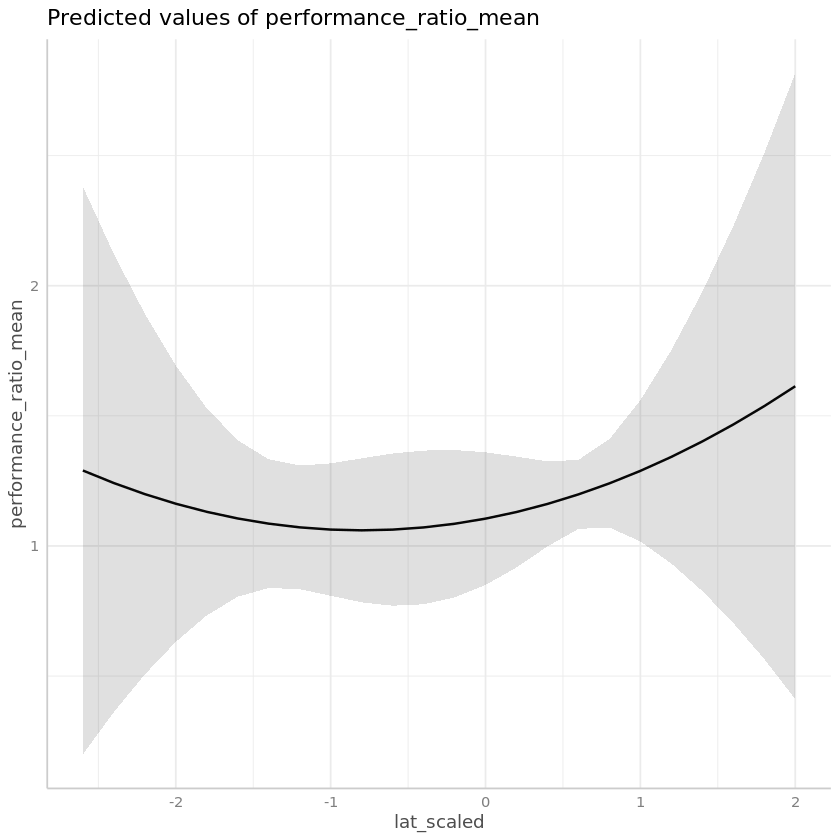

In [112]:
plot(ggeffect(simple_intense_re, terms='lat_scaled'))

## Absolute Latitude instead of Poly(2)

In [113]:
abslat_re = lmer(performance_ratio_mean ~ (abslat_scaled + sst_scaled  + season)^2 + (1 | isolate), data=mhwPerformance, )

In [114]:
summary(abslat_re)


Correlation matrix not shown by default, as p = 13 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: performance_ratio_mean ~ (abslat_scaled + sst_scaled + season)^2 +  
    (1 | isolate)
   Data: mhwPerformance

REML criterion at convergence: 26401.5

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-1.744 -0.091 -0.015  0.049 60.972 

Random effects:
 Groups   Name        Variance Std.Dev.
 isolate  (Intercept)  1.196   1.094   
 Residual             12.153   3.486   
Number of obs: 4919, groups:  isolate, 73

Fixed effects:
                             Estimate Std. Error         df t value Pr(>|t|)
(Intercept)                 1.210e+00  2.127e-01  1.162e+02   5.687 9.79e-08
abslat_scaled               1.826e-01  4.050e-01  2.228e+02   0.451  0.65253
sst_scaled                  1.046e-01  4.282e-01  2.178e+02   0.244  0.80729
seasonspring                4.669e-01  1.625e-01  4.839e+03   2.874  0.00407
seasonsummer               -1.846e-01  1.528e-01  4.845e+03  -1.208  0.22712
seaso

In [115]:
abslat_re = lmer(performance_ratio_mean ~ (abslat_scaled + sst_scaled  + season)^2 + (1 | isolate), data=intenseMhwPerformance, )

In [116]:
summary(abslat_re)


Correlation matrix not shown by default, as p = 13 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: performance_ratio_mean ~ (abslat_scaled + sst_scaled + season)^2 +  
    (1 | isolate)
   Data: intenseMhwPerformance

REML criterion at convergence: 6741.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.4143 -0.2473 -0.0043  0.1621 27.9994 

Random effects:
 Groups   Name        Variance Std.Dev.
 isolate  (Intercept) 0.1420   0.3768  
 Residual             0.7385   0.8593  
Number of obs: 2597, groups:  isolate, 66

Fixed effects:
                             Estimate Std. Error         df t value Pr(>|t|)
(Intercept)                   1.16987    0.07651  140.99655  15.290  < 2e-16
abslat_scaled                 0.14067    0.14263  294.11317   0.986  0.32481
sst_scaled                   -0.01955    0.15023  302.55615  -0.130  0.89656
seasonspring                  0.15813    0.05967 2583.48658   2.650  0.00810
seasonsummer                 -0.26490    0.05629 2580.15964  -4.70

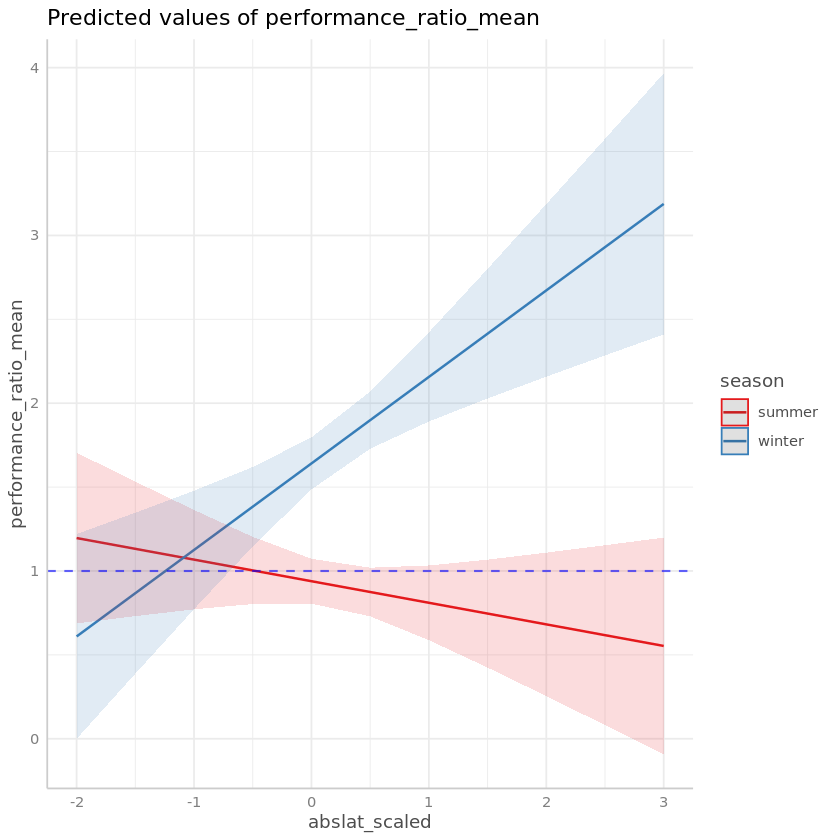

In [127]:
plot(ggeffect(abslat_re, terms=c('abslat_scaled', 'season [summer, winter]'))) + baseline_hline

In [ ]:
plot()

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


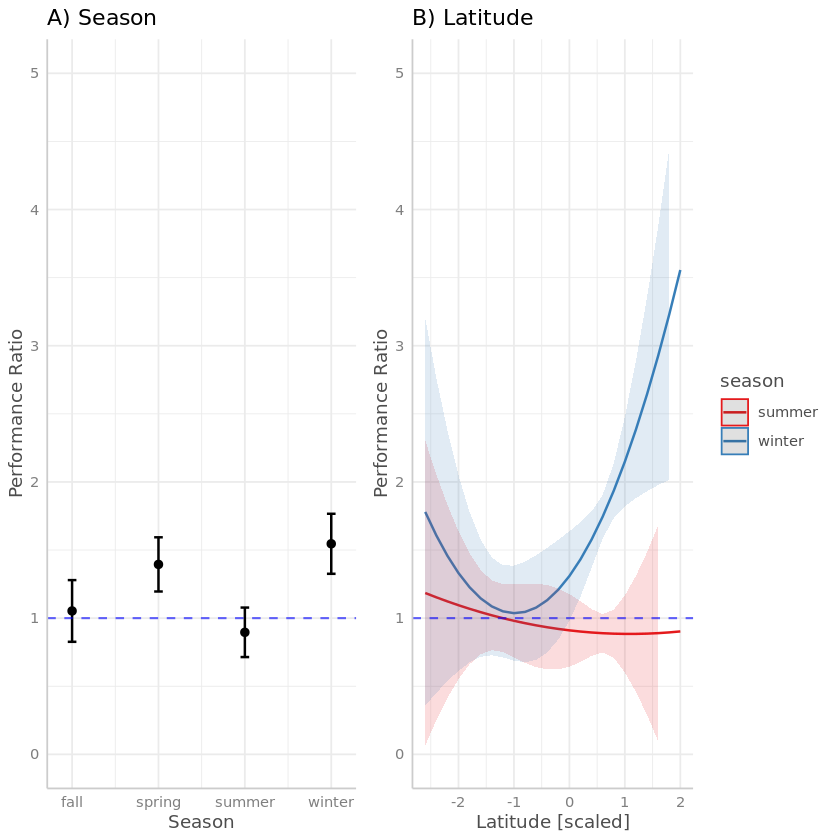

In [233]:
# png("./lat_season.png", width=1440, height=700, res=180)

seas = plot(ggeffect(simple_intense_scaled_re, terms='season')) + 
    baseline_hline + 
    xlab("Season") +
    ylab("Performance Ratio")  +
    ggtitle("A) Season") + 
    ylim(0, 5)



seaslat = plot(ggeffect(simple_intense_scaled_re, terms=c('lat_scaled', 'season [summer, winter]'))) +
    baseline_hline +
    xlab("Latitude [scaled]") +
    ylab("Performance Ratio")  +
    ggtitle("B) Latitude") + 
    ylim(0, 5)

    

grid.arrange(seas, seaslat, nrow=1, widths=c(1,1.3))
# dev.off()
# seaslat

In [130]:
summary(simple_intense_re)


Correlation matrix not shown by default, as p = 18 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: performance_ratio_mean ~ (poly(lat_scaled, 2) + sst_scaled +  
    season)^2 + (1 | isolate)
   Data: intenseMhwPerformance

REML criterion at convergence: 6679.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.4386 -0.2598 -0.0162  0.1726 28.0158 

Random effects:
 Groups   Name        Variance Std.Dev.
 isolate  (Intercept) 0.1464   0.3826  
 Residual             0.7373   0.8587  
Number of obs: 2597, groups:  isolate, 66

Fixed effects:
                                    Estimate Std. Error         df t value
(Intercept)                          1.20504    0.08161  133.86542  14.765
poly(lat_scaled, 2)1                 4.08730    4.05112  199.22881   1.009
poly(lat_scaled, 2)2                 9.45441    6.64490  236.04227   1.423
sst_scaled                           0.07561    0.15820  318.14282   0.478
seasonspring                         0.11758    0.06089 2572.71489   1

In [245]:
tab_model(simple_re, simple_intense_scaled_re, show.stat=TRUE, use.viewer=FALSE, dv.labels=c("Performance Ratio [all events]", "Performance Ratio [intense events]"), file = "simple_intense_re.html")

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


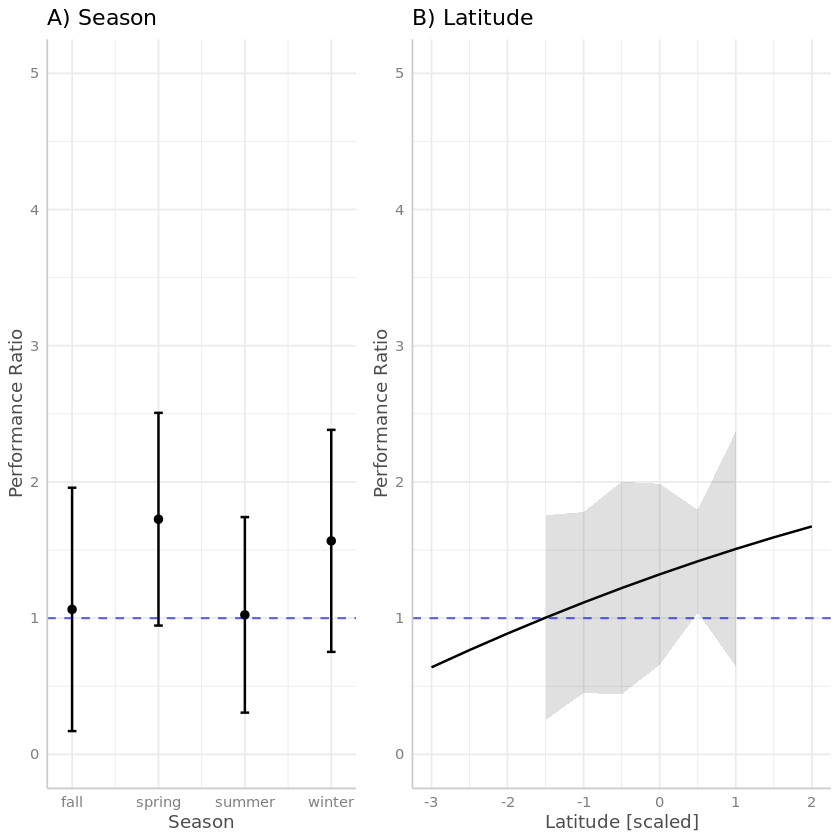

In [240]:
# png("./lat_season_all.png", width=1440, height=700, res=180)

seas = plot(ggeffect(simple_re, terms='season')) + 
    baseline_hline + 
    xlab("Season") +
    ylab("Performance Ratio")  +
    ggtitle("A) Season") + 
    ylim(0, 5)



seaslat = plot(ggeffect(simple_re, terms='lat_scaled')) +
    baseline_hline +
    xlab("Latitude [scaled]") +
    ylab("Performance Ratio")  +
    ggtitle("B) Latitude") + 
    ylim(0, 5)

    

grid.arrange(seas, seaslat, nrow=1, widths=c(1,1.3))
# dev.off()
# seaslat

In [246]:
anova(simple_re, simple_intense_re)

ERROR: Error in anova.merMod(simple_re, simple_intense_re): models were not all fitted to the same size of dataset


In [277]:
png("./compare_coefs.png", width=1440, height=950, res=180)
simple_coefs = plot_model(simple_re, ci.lvl=NA,  show.values = TRUE, value.offset=.4) + ylim(-20, 20) + ggtitle("A) All MHWs")
intense_coefs = plot_model(simple_intense_scaled_re,show.values = TRUE, value.offset=.4, ci.lvl=NA)+ theme(axis.text.y = element_blank()) + ylim(-20, 20) + ggtitle("B) Intense MHWs")
grid.arrange(simple_coefs, intense_coefs, nrow=1, widths=c(2., 1) )
dev.off()

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


png 
  2